In [1]:
def buildModel_TopLayer(input_shape):
    # load the train and test data and labels from temp
    #train_data = np.load(open('temp/bottleneck_features_train.npy'))

    # build a classifier model to put on top of the convolutional model.
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))       # for multi-class classification change  to Dense(num_classes, activation='softmax')
    return model

In [49]:
import os
import h5py
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from ipdb import set_trace as st
import time

%matplotlib inline

In [3]:
import sys

In [4]:
#!conda install --yes --prefix {sys.prefix} -c conda-forge opencv 

In [5]:
#!conda install --yes --prefix {sys.prefix} -c conda-forge/label/broken opencv

In [6]:
#!conda install --yes --prefix {sys.prefix} -c conda-forge ipdb

In [7]:
#!conda install --yes --prefix {sys.prefix} -c conda-forge/label/gcc7 ipdb

In [6]:
#K.set_image_dim_ordering('th')      # set model to be ordered in dimensions for theano

In [8]:
from keras.applications.densenet import DenseNet121

In [9]:
#(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000

# Build pre-trained classification model

In [10]:
from keras import Model
from keras.optimizers import Adam

In [11]:
base_model = DenseNet121(input_shape=(256, 256, 3),
                             include_top=False,
                             weights='imagenet')

In [12]:
def build_topmodel(input_dim):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_dim))
    top_model.add(Dense(1024, activation='relu'))
    top_model.add(Dropout(0.6))
    top_model.add(Dense(1, activation='sigmoid'))
    return top_model

In [13]:
top_model = build_topmodel(base_model.output_shape[1:])

In [14]:
top_model.load_weights('../data/weights/top_model.h5')

In [15]:
model_class = Model(inputs=base_model.input,
                      outputs=top_model(base_model.output))

In [16]:
model_class.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
                      metrics=['categorical_accuracy'])

In [17]:
#set layers non-trainable
for layer in model_class.layers:
    layer.trainable = False

In [18]:
#model.summary() 
#Input: (None, 256, 256, 3)
#Output: (None, 1)

# Build segmentation model

In [19]:
from keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, SpatialDropout2D
from keras.layers.merge import concatenate

In [20]:
def double_conv_layer(x, size, dropout, batch_norm):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

In [21]:
class Unet:
    def __init__(self, insize, outsize, input_channels, output_mask_channel):
        self.insize = insize
        self.outsize = outsize
        self.input_channels = input_channels
        self.output_mask_channel = output_mask_channel

    def _build_unet(self, dropout_val=0.2, batch_norm=True):

        input_image = Input((self.insize, self.insize, self.input_channels))

        def go_forward(input_image):
            axis = 3
            filters = 32

            conv_224 = double_conv_layer(input_image, filters, 0, batch_norm)
            pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

            conv_112 = double_conv_layer(pool_112, 2 * filters, 0, batch_norm)
            pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

            conv_56 = double_conv_layer(pool_56, 4 * filters, 0, batch_norm)
            pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

            conv_28 = double_conv_layer(pool_28, 8 * filters, 0, batch_norm)
            pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

            conv_14 = double_conv_layer(pool_14, 16 * filters, 0, batch_norm)
            pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

            conv_7 = double_conv_layer(pool_7, 32 * filters, 0, batch_norm)

            up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
            up_conv_14 = double_conv_layer(up_14, 16 * filters, 0, batch_norm)

            up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
            up_conv_28 = double_conv_layer(up_28, 8 * filters, 0, batch_norm)

            up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
            up_conv_56 = double_conv_layer(up_56, 4 * filters, 0, batch_norm)

            up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
            up_conv_112 = double_conv_layer(up_112, 2 * filters, 0, batch_norm)

            up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
            up_conv_224 = double_conv_layer(up_224, filters, dropout_val, batch_norm)

            conv_final = Conv2D(self.output_mask_channel, (1, 1), name = "trained_unet")(up_conv_224)
            conv_final = Activation('sigmoid')(conv_final)

            conv_final_final = concatenate([conv_final, conv_final, conv_final], axis = axis)
            return conv_final_final


        mask = go_forward(input_image)

        model = Model(input_image, mask, name="ZF_UNET_224")

        return model

In [22]:
unet = Unet(insize = 256, outsize = 256, input_channels = 3, output_mask_channel = 1)

In [23]:
unet_model = unet._build_unet()

In [24]:
unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [25]:
model_whole = Model(inputs=unet_model.input,
                      outputs=top_model(unet_model.output))

In [26]:
import keras
from keras.layers import dot
from keras import layers

In [27]:
def whole_model(unet_model, model_class):
    
    input_background = Input((unet_model.input.shape[1], 
                              unet_model.input.shape[1], 
                              unet_model.input.shape[-1]))


    
    back_maskdot = keras.layers.multiply([unet_model.input, unet_model.output])
    
    image_maskdot = keras.layers.multiply([input_background, unet_model.output])
    
    
    #model1 = Model(inputs = unet_model.input, outputs =  model_class(back_maskdot))
    #model2 = Model(inputs = [input_background, unet_model.input], outputs =  model_class(image_maskdot))
    
    X_final = layers.concatenate([model_class(back_maskdot), model_class(image_maskdot)], axis=-1)

    last_model = Model(inputs = [unet_model.input, input_background], output = X_final)


    return last_model
        
        

In [28]:
from keras.layers import Lambda

In [29]:
#back_maskdot = K.dot(unet_model.input, unet_model.output)

#fdfdf = keras.layers.multiply([unet_model.input, unet_model.output])
#ddffl = Model(inputs = unet_model.input, outputs = model_class(fdfdf))

In [30]:
#ddffl.summary()

In [31]:
last_model = whole_model(unet_model, model_class)

/Users/romandegtyarev/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


In [32]:
last_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [32]:
# x ->segmentation_model -> mask, mask * image + (1 - mask) * background
#input_background = Input((insize, insize, input_channels))

In [33]:
# выход сегментации mask 

# define loss function

In [34]:
def double_binary_crossentropy_loss(y_true, y_pred):
    img_bc = keras.losses.binary_crossentropy(y_true[:, 0], y_pred[:, 0])
    mask_bc = keras.losses.binary_crossentropy(y_true[:, 1], y_pred[:, 1])
    
    return img_bc - mask_bc
    #return keras.losses.binary_crossentropy(img_bc, 1 - mask_bc)

In [35]:
from keras.optimizers import Adam

In [36]:
adam = Adam()

In [37]:
last_model.compile(optimizer = adam, loss = double_binary_crossentropy_loss)

# get images

In [36]:
from os import listdir
from os.path import isfile, join

In [37]:
class FolderViewer:
    def __init__(self):
        pass

    def get_folder_list(self, path):
        return os.listdir(path)

    def get_files(self, path, format = 'jpg'):
        onlyfiles = [f for f in listdir(path) if (isfile(join(path, f))) and f.split('.')[-1] == format]
        return onlyfiles

    def create_dir(self, path):
        if not os.path.exists(path):
            os.makedirs(path)

    def file_accessible(self, filepath, mode):
        ''' Check if a file exists and is accessible. '''
        try:
            f = open(filepath, mode)
            f.close()
        except IOError as e:
            return False

        return True

In [38]:
from tqdm import tqdm

viewer = FolderViewer()

data_path = "../data/"
melanoma_path = data_path + "melanoma/"
benign_path = data_path + "benign/"
out_path_numpy = data_path + "out/numpy/"

insize = 256

import cv2

def read_data(folder_name="melanoma", is_save = True):
    if folder_name == "melanoma":
        files = viewer.get_files(melanoma_path, format='jpg')
        temp_inpath = melanoma_path

    elif folder_name == "benign":
        files = viewer.get_files(benign_path, format='jpg')
        temp_inpath = benign_path

    else:
        print("folder_name should be melanoma or benign")
        return

    data = np.zeros((len(files), insize, insize, 3))
    for i, file in enumerate(tqdm(files)):
        raw_img = cv2.imread(temp_inpath + file)
        img = cv2.resize(raw_img,  (insize,insize), interpolation = cv2.INTER_CUBIC)
        data[i] = img
    if is_save:
        if folder_name == "melanoma":
            viewer.create_dir(out_path_numpy + "melanoma/")
            np.save(out_path_numpy + "melanoma/" + "data.npy" , data)

        if folder_name == "benign":
            viewer.create_dir(out_path_numpy + "benign/")
            np.save(out_path_numpy + "benign/" + "data.npy", data)

    return data

def load_data(folder_name = "melanoma"):
    out_path_numpy = data_path + "out/numpy/"
    if folder_name == "melanoma":
        path = out_path_numpy + "melanoma/" + "data.npy"
    elif folder_name == "benign":
        path = out_path_numpy + "benign/" + "data.npy"
    else:
        print("folder_name should be melanoma or benign")
        return

    if viewer.file_accessible(path, "r"):
        data = np.load(path)
    else:
        print("File isn't found, start preparing ...")
        data = read_data(folder_name = folder_name, is_save=True)

    return data

In [39]:
import gc

In [40]:
#melanoma = 1, benign = 0, background = 0

melanoma_data = read_data(folder_name="melanoma")
benign_data = read_data(folder_name="benign")
X_train =  np.vstack((melanoma_data, benign_data))

y_train = np.ones((len(melanoma_data) + len(benign_data)))

for i in range(len(melanoma_data), len(melanoma_data) + len(benign_data)):
    y_train[i] = 0

100%|██████████| 3050/3050 [01:39<00:00, 30.75it/s]


In [42]:
np.random.shuffle(X_train), np.random.shuffle(y_train)

(None, None)

In [43]:
print(X_train.shape, y_train.shape)

(5136, 256, 256, 3) (5136,)


In [44]:
background = np.random.normal(0, 0.8, (len(melanoma_data) + len(benign_data)) * insize * insize * 3)

background = background.reshape(len(y_train), insize, insize, 3)

y_back = np.zeros(len(melanoma_data) + len(benign_data))

# Let's see random images

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


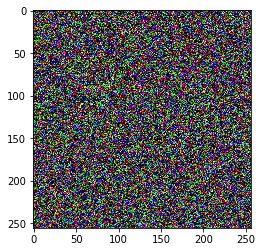

In [46]:
plt.imshow(background[100])

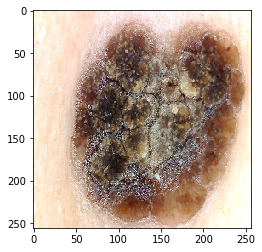

In [47]:
plt.imshow(cv2.cvtColor(X_train[10].astype(np.uint8), cv2.COLOR_BGR2RGB))

# fit model

In [49]:
y_whole = np.swapaxes(np.vstack((y_train, y_back)), 0, 1)

In [50]:
print(X_train.shape, y_whole.shape)

(5136, 256, 256, 3) (5136, 2)


In [51]:
last_model.fit(x = [X_train, background], 
               y = y_whole, 
               batch_size=3, 
               epochs=50, 
               validation_split=0.1, 
               shuffle=True)

Train on 4622 samples, validate on 514 samples
Epoch 1/50
4622/4622 [==============================] - 296s 64ms/step - loss: 0.3736 - val_loss: -1.5500
Epoch 2/50
4622/4622 [==============================] - 273s 59ms/step - loss: -0.2637 - val_loss: -1.7762
Epoch 3/50
4622/4622 [==============================] - 273s 59ms/step - loss: -0.2949 - val_loss: -1.9597
Epoch 4/50
4622/4622 [==============================] - 272s 59ms/step - loss: -1.1700 - val_loss: -1.2773
Epoch 5/50
4622/4622 [==============================] - 272s 59ms/step - loss: -0.9617 - val_loss: -0.9555
Epoch 6/50
4622/4622 [==============================] - 272s 59ms/step - loss: -1.3986 - val_loss: 0.6366
Epoch 7/50
4622/4622 [==============================] - 272s 59ms/step - loss: -1.2901 - val_loss: -0.6089
Epoch 8/50
4622/4622 [==============================] - 272s 59ms/step - loss: -1.3605 - val_loss: 0.9144
Epoch 9/50
4622/4622 [==============================] - 271s 59ms/step - loss: -1.4831 - val_loss: 0

# Test trained segmentation

In [52]:
for layer in last_model.layers:
    print(layer.name)

input_2
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d_1
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_2
conv2d_5
batch_normalization_5
activation_5
conv2d_6
batch_normalization_6
activation_6
max_pooling2d_3
conv2d_7
batch_normalization_7
activation_7
conv2d_8
batch_normalization_8
activation_8
max_pooling2d_4
conv2d_9
batch_normalization_9
activation_9
conv2d_10
batch_normalization_10
activation_10
max_pooling2d_5
conv2d_11
batch_normalization_11
activation_11
conv2d_12
batch_normalization_12
activation_12
up_sampling2d_1
concatenate_1
conv2d_13
batch_normalization_13
activation_13
conv2d_14
batch_normalization_14
activation_14
up_sampling2d_2
concatenate_2
conv2d_15
batch_normalization_15
activation_15
conv2d_16
batch_normalization_16
activation_16
up_sampling2d_3
concatenate_3
conv2d_17
batch_normalization_17
activation_17
conv2d_18
batch_normalization_18
activation_18
up_

In [82]:
layer_name = "concatenate_6"

l = 12
r = l + 1

#predict 
intermediate_layer_model = Model(inputs=last_model.input,
                                 outputs=last_model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict([X_train[l:r], background[l:r]])

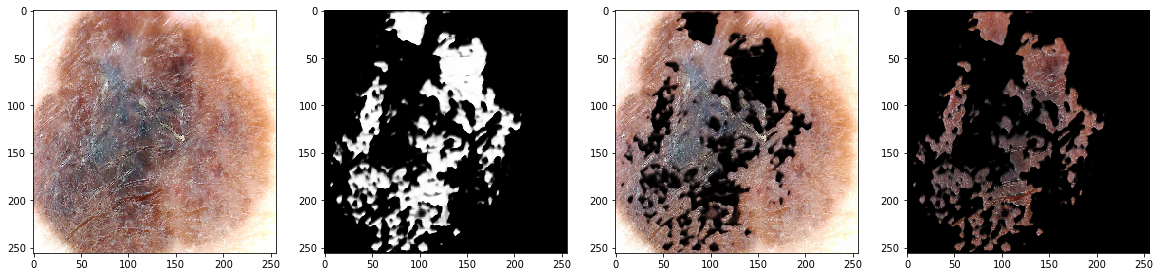

In [83]:
#and draw
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(np.squeeze(X_train[l]).astype(np.uint8), cv2.COLOR_BGR2RGB))
ax[1].imshow(np.squeeze(intermediate_output))
ax[2].imshow(cv2.cvtColor(np.squeeze(X_train[l] * (1 - intermediate_output)).astype(np.uint8), cv2.COLOR_BGR2RGB))
ax[3].imshow(cv2.cvtColor(np.squeeze(X_train[l] * intermediate_output).astype(np.uint8), cv2.COLOR_BGR2RGB))

In [58]:
last_model.save_weights('my_model_weights.h5')

# Load weights

In [33]:
last_model.load_weights("../data/weights/my_model_weights.h5")

# Test again

In [52]:
layer_name = "concatenate_6"

l = 13
r = l + 1

#predict 
intermediate_layer_model = Model(inputs=last_model.input,
                                 outputs=last_model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict([X_train[l:r], background[l:r]])

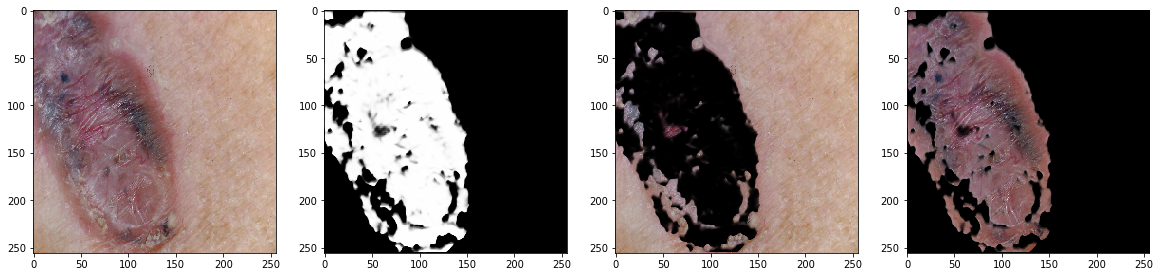

In [53]:
#and draw
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(np.squeeze(X_train[l]).astype(np.uint8), cv2.COLOR_BGR2RGB))
ax[1].imshow(np.squeeze(intermediate_output))
ax[2].imshow(cv2.cvtColor(np.squeeze(X_train[l] * (1 - intermediate_output)).astype(np.uint8), cv2.COLOR_BGR2RGB))
ax[3].imshow(cv2.cvtColor(np.squeeze(X_train[l] * intermediate_output).astype(np.uint8), cv2.COLOR_BGR2RGB))

# Test ISIC

In [85]:
def IOU_metric(mask_original, mask_predicted):
    mask_original_flatten = mask_original.flatten()
    mask_predicted_flatten = mask_predicted.flatten()
    intersection = np.sum(mask_original_flatten * mask_predicted_flatten)
    union = np.sum(mask_original_flatten) + np.sum(mask_predicted_flatten)
    iou = (2.0 * intersection + 1.0) / (union + 1.0)
    return iou

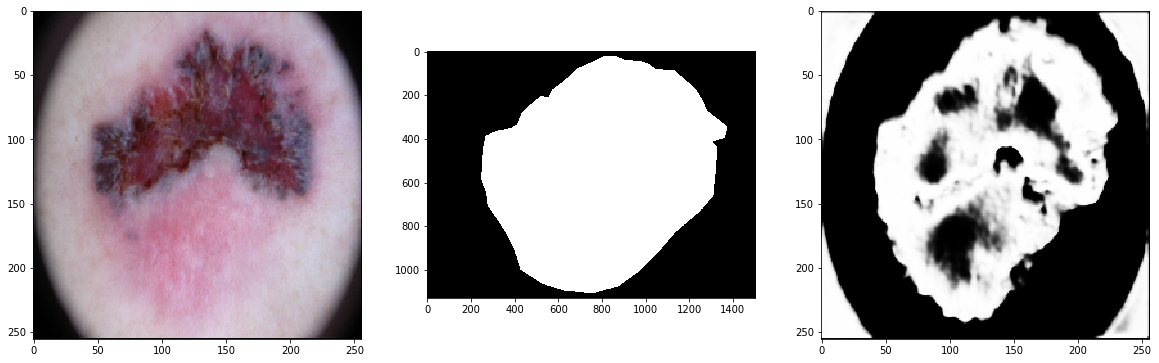

IOU between test and predicted: 1.3845455555302701


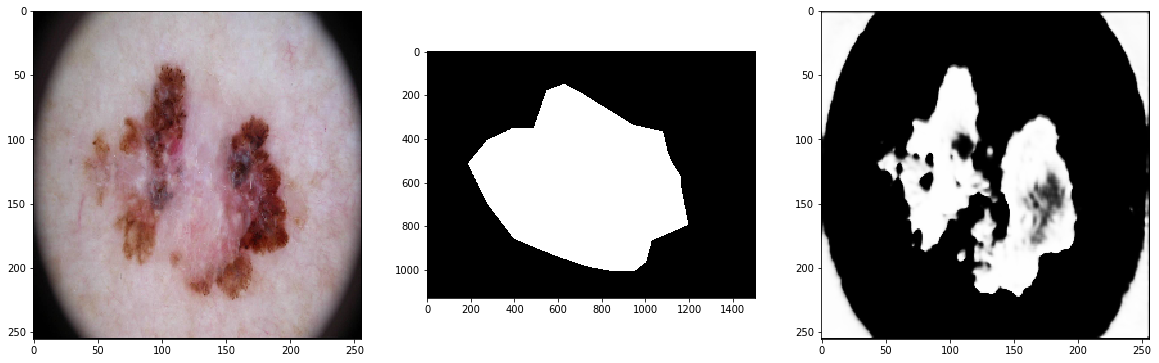

IOU between test and predicted: 1.0549742398676567


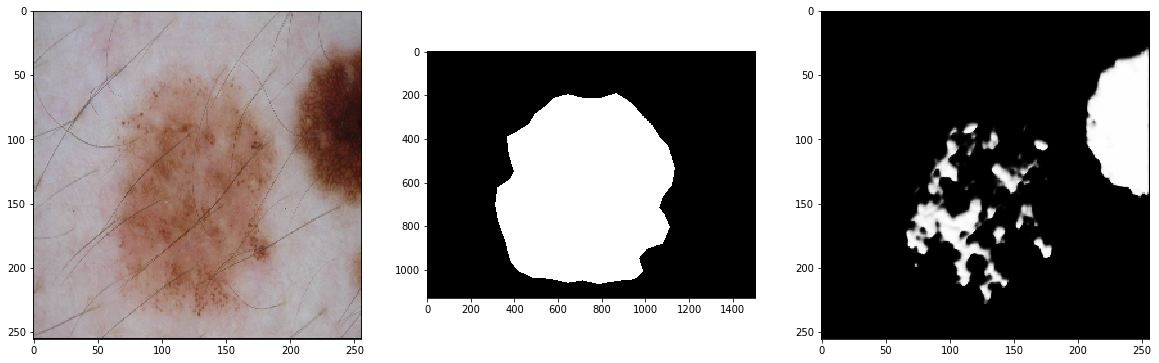

IOU between test and predicted: 0.26768010029519856


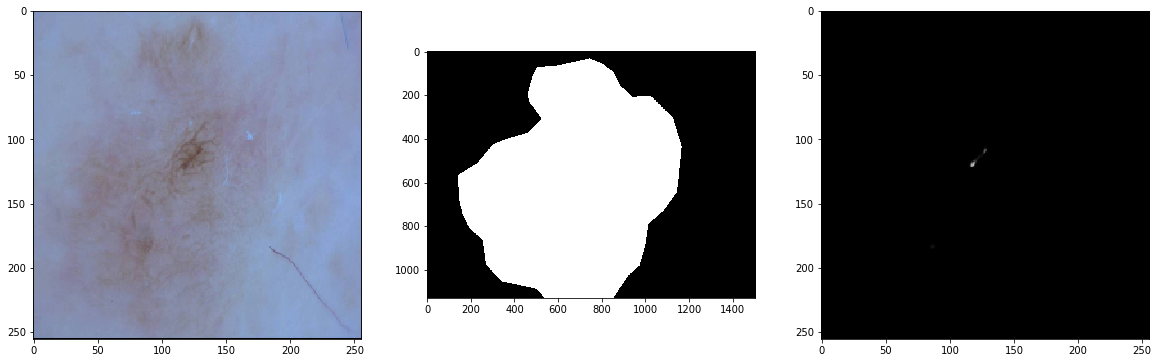

IOU between test and predicted: 0.0008381299507554756


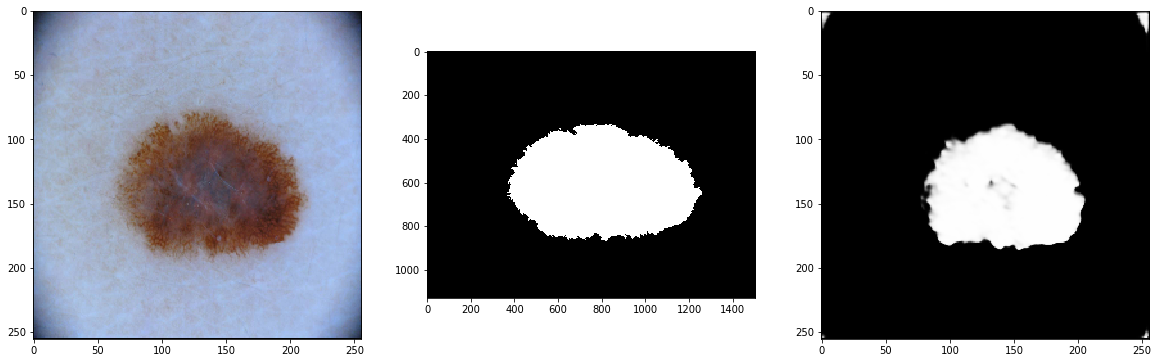

IOU between test and predicted: 1.3258877862311438


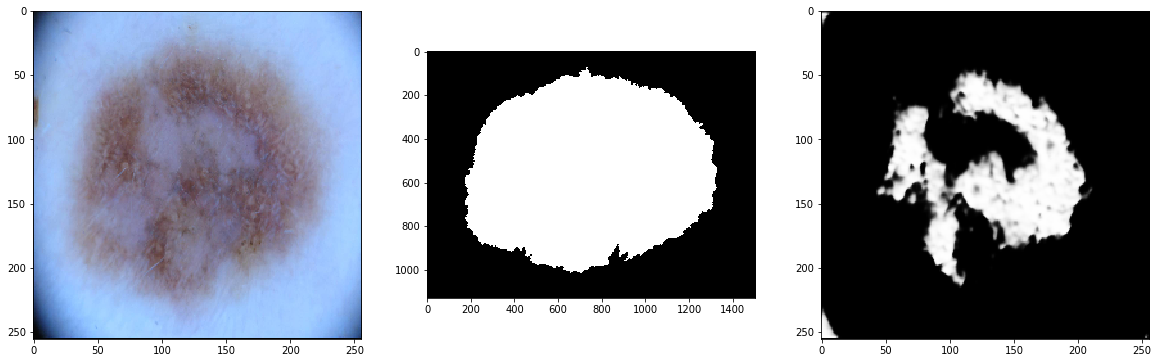

IOU between test and predicted: 0.6543858254970788


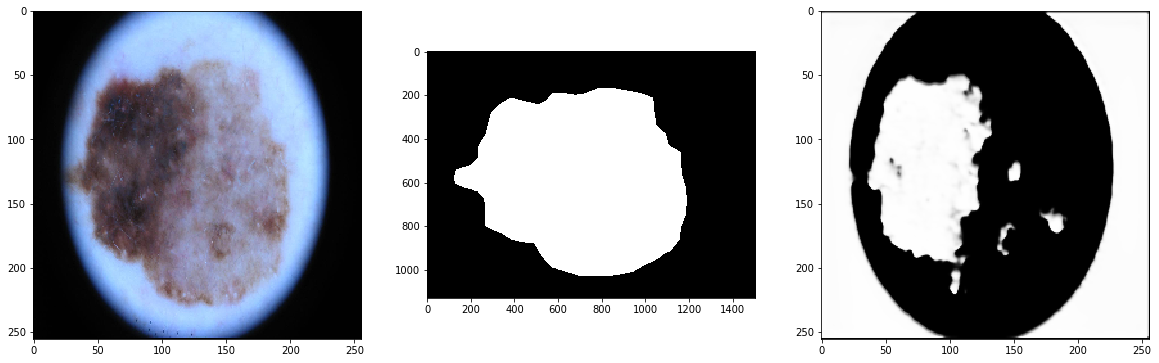

IOU between test and predicted: 0.7935402925463388


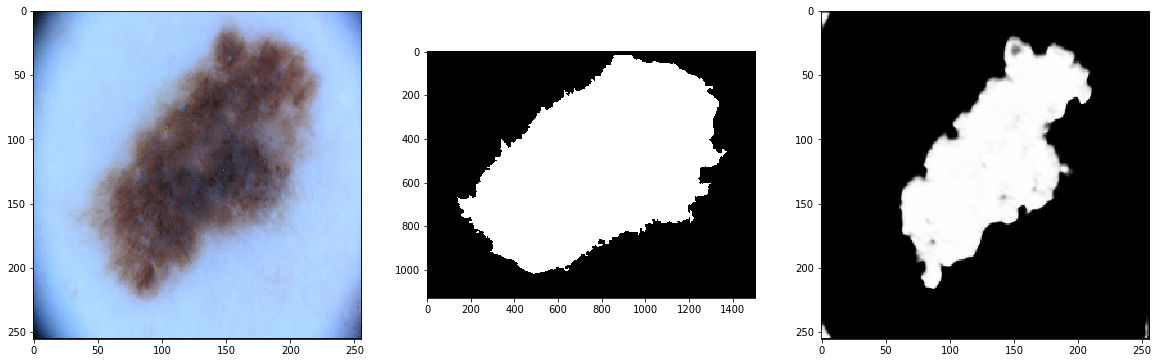

IOU between test and predicted: 0.9498819396092174


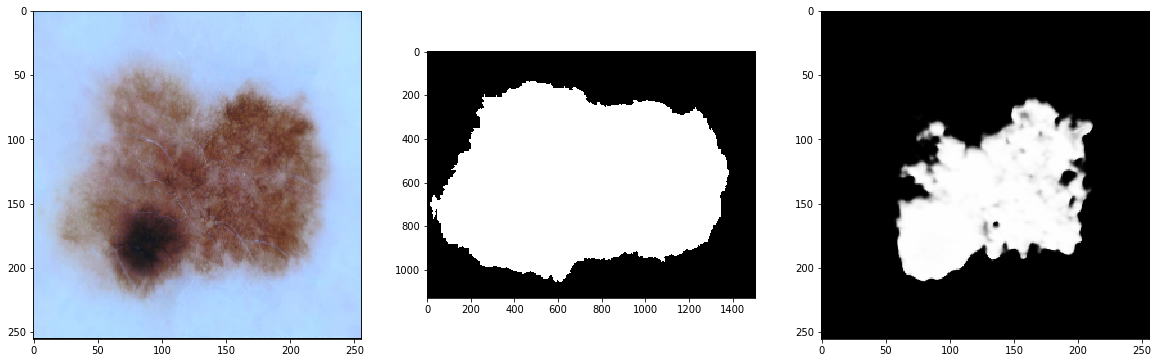

IOU between test and predicted: 0.7707996456123333


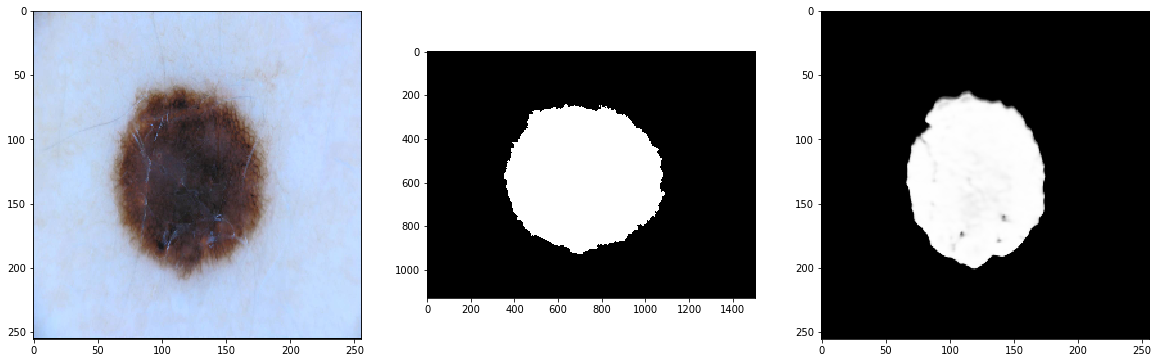

IOU between test and predicted: 1.491315104017504


In [90]:
l = 13
r = l + 1
#it's for fake background

for i in range(30,40,1):

    raw_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Images/ISIC_00000{}.jpeg".format(i))
    mask_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Segmentation/ISIC_00000{}_expert.png".format(i))
    img = cv2.resize(raw_img,  (insize,insize), interpolation = cv2.INTER_CUBIC)


    intermediate_output = intermediate_layer_model.predict([np.expand_dims(img, axis = 0), background[l:r]])

    fig, ax = plt.subplots(1, 3, figsize = (20, 10))
    ax[0].imshow(cv2.cvtColor(np.squeeze(img).astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax[1].imshow(mask_img.astype(np.uint8))
    ax[2].imshow(np.squeeze(intermediate_output))
    plt.show()
    
    mask_original = cv2.resize(mask_img.astype(np.uint8),  (insize, insize), interpolation = cv2.INTER_CUBIC)
    mask_predicted = np.squeeze(intermediate_output)

    print("IOU between test and predicted: {}".format(IOU_metric(mask_original, mask_predicted)))

# Lets average iou 

In [ ]:
l = 13
r = l + 1
#it's for fake background

ious_list = []
for i in tqdm(range(10,200,1)):
    if i < 10:
        raw_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Images/ISIC_000000{}.jpeg".format(i))
        mask_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Segmentation/ISIC_000000{}_expert.png".format(i))
    if i < 100:
        raw_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Images/ISIC_00000{}.jpeg".format(i))
        mask_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Segmentation/ISIC_00000{}_expert.png".format(i))
    else:
        raw_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Images/ISIC_0000{}.jpeg".format(i))
        mask_img = cv2.imread("../extra_libs/ISIC-Archive-Downloader/Data/Segmentation/ISIC_0000{}_expert.png".format(i))
    try:
        img = cv2.resize(raw_img,  (insize,insize), interpolation = cv2.INTER_CUBIC)
        intermediate_output = intermediate_layer_model.predict([np.expand_dims(img, axis = 0), background[l:r]])
    
        mask_original = cv2.resize(mask_img.astype(np.uint8),  (insize, insize), interpolation = cv2.INTER_CUBIC)
        mask_predicted = np.squeeze(intermediate_output)
    
    
        temp_iou = IOU_metric(mask_original, mask_predicted)
        ious_list.append(temp_iou)
    except Exception as e:
        print("fail on {}".format(i))
        print(e)
        continue



 61%|██████    | 115/190 [01:16<00:50,  1.49it/s]

In [93]:
print("Average iou on test images: {}".format(np.mean(ious_list)))

Average iou on test images: 1.0207325280884547
